# A pair of Goodwin oscillators

Trying this instead of the thalamic model so that debugging isn't so goddamn slow.

# Inits

## Imports

In [160]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
# user-defined
import nmCoupling as nm
import response as rp

import gw2

import lib.util
import lib.rhs

from lib.util import (get_phase, freq_est, get_tongue_1d,
                      pl_exist_1d,get_period)
from lib.rhs import (rhs_avg_2d, _redu_moving, 
                     _redu_moving_avg, rhs_avg_1d, rhs_avg_1dc)


from importlib import reload
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sym

from scipy.optimize import root,bisect
from copy import deepcopy

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

nmc = nm.nmCoupling
rsp = rp.Response

## Dicts

In [72]:
kw_sim = {'rtol':1e-10,'atol':1e-10,'method':'LSODA'}

In [73]:
pd1 = {'v1':.84,'v2':.42,'v4':.35,'v6':.35,'v8':1,
           'k1':1,'k2':1,'k3':.7,'k4':1,'k5':.7,
           'k6':1,'k7':.35,'k8':1,'K':0.5,'kc':1,
           'n':6,'L':0,'eps':0,'om':1,'om_fix':1}

In [74]:
kws1 = {'var_names':['x','y','z','v'],
        'pardict':pd1,
        'rhs':gw2.rhs,
        'coupling':gw2.coupling,
        'init':np.array([.3882,.523,1.357,.4347,24.2]),
        'TN':2000,
        'trunc_order':2,
        'z_forward':False,
        'i_forward':False,
        'i_bad_dx':[False,True,False,False,False],
        'max_iter':20,
        'rtol':1e-12,
        'atol':1e-12,
        'rel_tol':1e-9,
        'save_fig':False}

## Defs

In [75]:
x_temp = np.linspace(-np.pi,3*np.pi,500)

In [76]:
def bif1d(a,eps,del1):
    """
    for coupling only
    """

    y = _redu(0,x_temp,a,eps,del1)

    # get all zeros
    z1 = x_temp[1:][(y[1:]>0)*(y[:-1]<=0)]
    z2 = x_temp[1:][(y[1:]<0)*(y[:-1]>=0)]

    return z1,z2

In [77]:
def add_diagram(axs,a,del1,eps_list):
    zu_list = []
    zs_list = []

    zu = []
    zs = []

    for eps in eps_list:
        z1,z2 = bif1d(a,eps,del1)

        zu.append(np.mod(z1,2*np.pi))
        zs.append(np.mod(z2,2*np.pi))

    for xe, ye in zip(eps_list, zu):
        axs.scatter([xe] * len(ye), ye,s=2,c='red')

    for xe, ye in zip(eps_list, zs):
        axs.scatter([xe] * len(ye), ye,s=2,c='k')

    axs.set_ylim(-.1,2*np.pi+.1)
    axs.set_xlim(eps_list[0],eps_list[-1])
    

### rhs

In [78]:
def _full(t,y,a,eps,del1,sign=1):
    pd1 = a.system1.pardict;pd2 = a.system2.pardict
    om_fix = pd1['om_fix0']
    y1 = y[:4];y2 = y[4:]
    out1 = gw2.rhs(t,y1,pd1,'val',0) + sign*eps*gw2.coupling(y,pd1,'val',0) + eps*del1
    out2 = gw2.rhs(t,y2,pd2,'val',1) + sign*eps*gw2.coupling(list(y2)+list(y1),pd2,'val',1)
    return np.array(list(out1)+list(out2))

In [159]:
def _redu(t,y,a,eps,del1):
    n = a._n[1];m = a._m[1]
    system1 = a.system1; system2 = a.system2
    h = 0
    for k in range(a.system1.miter):
        het = del1*np.mean(system1.z['dat'][k][:,0])
        h += (eps/2)**(k+1)*(het*8 + (system1.h['lam'][k](y) - system2.h['lam'][k](y)))
    return h*a.system1.pardict['om_fix0']*n/m/2

In [80]:
def _redu_split(t,y,a,eps,del1):
    th1,th2 = y
    n = a._n[1];m = a._m[1]
    system1 = a.system1; system2 = a.system2
    pd1 = system1.pardict
    h1 = 0;h2 = 0
    for k in range(a.system1.miter):
        het = del1*np.mean(system1.z['dat'][k][:,0])
        h1 += eps**(k+1)*(het + system1.h['lam'][k](th1-a12.om*th2))
        h2 += eps**(k+1)*system2.h['lam'][k](th1-a12.om*th2)
    return np.array([h1,h2])

In [81]:
# def _redu2(t,y,a,eps,del1):
#     n = a._n[1];m = a._m[1]
#     system1 = a.system1; system2 = a.system2
#     h = 0
#     for i in range(system1.miter):
#         h += eps**(i+1)*(4*del1*np.mean(system1.z['dat'][i]) + system1.h['lam'][i](y) - system2.h['lam'][i](y))
#     return h*n/m

## Initialize Response Functions

In [82]:
system1 = rsp(idx=0,model_name='gw0',**kws1)
system2 = rsp(idx=1,model_name='gw1',**kws1)

* Loading LC data...
self.T 6.283185307179586 omfix 3.8590183230656914
* Loading monodromy...
* Floquet Exponent kappa =-0.15846659975461394
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...
* Loading LC data...
self.T 6.283185307179586 omfix 3.8590183230656914
* Loading monodromy...
* Floquet Exponent kappa =-0.15846659975461394
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...


# 1:1

In [101]:
a11 = nm.nmCoupling(system1,system2,
                    #recompute_list=['p_data_gw0','p_data_gw1','h_data_gw0','h_data_gw1'],
                    #recompute_list=['h_data_gw0','h_data_gw1'],
                    #recompute_list=recompute_list,
                    _n=('om0',1),_m=('om1',1),
                    NP=600,
                    NH=600,
                    save_fig=True)

* Loading p symbolic...
* Loading p symbolic...
* Loading H symbolic...
* Loading H symbolic...
* Loading H gw0, order=0...
* Loading H gw1, order=0...
* Loading H gw0, order=1...
* Loading H gw1, order=1...
* Loading H gw0, order=2...
* Loading H gw1, order=2...


In [151]:
eps11 = .1
del11 = -0.1
th_init11 = 4

## Phase Plane

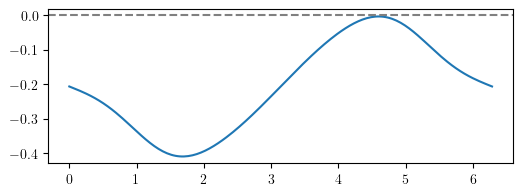

In [163]:
x_temp2 = np.linspace(0,2*np.pi,200)

rhs = _redu(0,x_temp2,a11,eps11,del11)

fig,axs = plt.subplots(figsize=(6,2))
axs.plot(x_temp2,rhs)
axs.axhline(0,0,2*np.pi,ls='--',color='gray')

## Integrate

In [153]:
dt = .01;T=2000
t11 = np.arange(0,T,dt)
args11 = {'args':(a11,eps11,del11),'t_eval':t11,**kw_sim}

In [154]:
y0a = a11.system1.lc['dat'][int((th_init11/(2*np.pi))*a11.system1.TN),:]
y0b = a11.system2.lc['dat'][int((0/(2*np.pi))*a11.system2.TN),:]

y0 = np.array([y0a,y0b]).flatten()

solf11 = solve_ivp(_full,[0,t11[-1]],y0,**args11)

In [155]:
solr11 = solve_ivp(_redu,[0,t11[-1]],[th_init11],**args11)

In [156]:
# fig,axs = plt.subplots(figsize=(10,4))
# axs.plot(solf11.t,solf11.y.T[:,0])
# axs.plot(solf11.t,solf11.y.T[:,4])
# #axs.set_xlim(sol_full.t[-1]-200,sol_full.t[-1])
# axs.set_xlim(t11[-1]-100,t11[-1])

In [157]:
tp11a, phase11a = get_phase(t11,solf11.y.T[:,:4],skipn=20,system1=a11.system1)
tp11b, phase11b = get_phase(t11,solf11.y.T[:,4:],skipn=20,system1=a11.system2)

## Full vs phase

(0.0, 6.283185307179586)

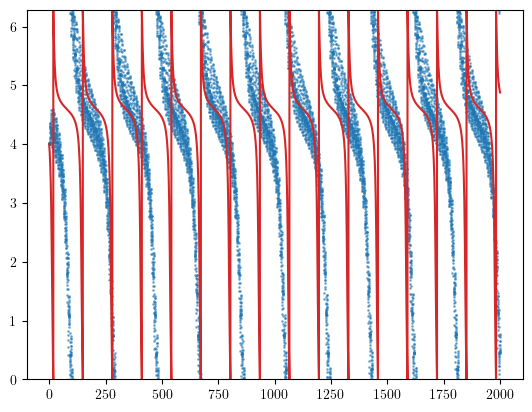

In [158]:
fig,axs = plt.subplots()
y = np.mod(phase11a - a11.om*phase11b,2*np.pi)
axs.scatter(tp11a,y,s=1,alpha=.5)
axs.plot(t11,np.mod(solr11.y.T,2*np.pi),color='tab:red')
#axs.scatter(sol_full.t[::skipn],np.mod(phase2,1),s=1)
axs.set_ylim(0,2*np.pi)

## Bifurcations

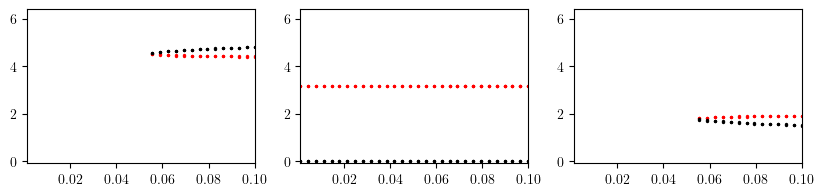

In [167]:
fig,axs=plt.subplots(1,3,figsize=(10,2))

del_list11 = np.linspace(-.095,.095,len(axs))
eps_list11 = np.linspace(.001,.1,30)

for k in range(len(del_list11)):
    add_diagram(axs[k],a11,del_list11[k],eps_list11)

# 1:2

In [97]:
a12 = nm.nmCoupling(system1,system2,
                    #recompute_list=['p_data_gw0','p_data_gw1','h_data_gw0','h_data_gw1'],
                    #recompute_list=['h_data_gw0','h_data_gw1'],
                    #recompute_list=recompute_list,
                    _n=('om0',1),_m=('om1',2),
                    NP=700,
                    NH=700,
                    save_fig=False)

* Loading p symbolic...
* Loading p symbolic...
* Loading H symbolic...
* Loading H symbolic...
* Loading H gw0, order=0...
* Loading H gw1, order=0...
* Loading H gw0, order=1...
* Loading H gw1, order=1...
* Loading H gw0, order=2...
* Loading H gw1, order=2...


## Aliases

In [98]:
pd1 = a12.system1.pardict;pd2 = a12.system2.pardict
n = a12._n[1];m = a12._m[1]
x = a12.x;dx = a12.dx
s = x*m;ds = dx*m
K = pd1['K0'];kc = pd1['kc0']
om = a12.om

## Coupling Parameters

In [99]:
eps12 = .01
del12 = 1e-4
th_init12 = 0

First order starts losing accuracy around eps = 0.025 as eps increases (the reduced model reaches the same fixed point as the full model). Even at eps=0.02, the reduced and full models don't coincide in transients despite the long-term convergence.

Using order eps^2 at eps = 0.025 results in WORSE performance... So clearly if not p then there is something wrong with calculating h functions...

There is a saddle-node in the phase-locked states around eps=0.05 to eps=0.07 in the full model. the reduced models all experience this bifurcation much earlier. Which is fine. I'm only using 2 orders.

## Phase plane

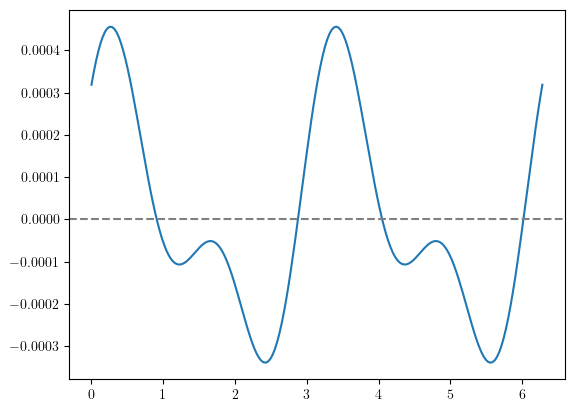

In [100]:
x_temp2 = np.linspace(0,2*np.pi,200)

# def _redu(t,y,a,eps,del1):
#     n = a._n[1];m = a._m[1]
#     system1 = a.system1; system2 = a.system2
#     h = 0
#     for i in range(system1.miter):
#         h += eps**(i+1)*(4*del1*np.mean(system1.z['dat'][i]) + system1.h['lam'][i](-y+np.pi/4) - system2.h['lam'][i](-y+np.pi/4))
#     return h*n/m

rhs = _redu(0,x_temp2,a12,eps12,del12)

fig,axs = plt.subplots()
axs.plot(x_temp2,rhs)
axs.axhline(0,0,2*np.pi,ls='--',color='gray')

## Integrate

In [82]:
dt = .01;T=15000
t12 = np.arange(0,T,dt)
args12 = {'args':(a12,eps12,del12),'t_eval':t12,**kw_sim}

In [83]:
y0a = a12.system1.lc['dat'][int((th_init12/(2*np.pi))*a12.system1.TN),:]
y0b = a12.system2.lc['dat'][int((0/(2*np.pi))*a12.system2.TN),:]

y0 = np.array([y0a,y0b]).flatten()

solf12 = solve_ivp(_full,[0,t12[-1]],y0,**args12)

In [84]:
solr12 = solve_ivp(_redu,[0,t12[-1]],[th_init12],**args12)

In [85]:
# solrs12 = solve_ivp(_redu_split,[0,t12[-1]],[th_init12,0],**args12)

(14984.70681469282, 14990.99)

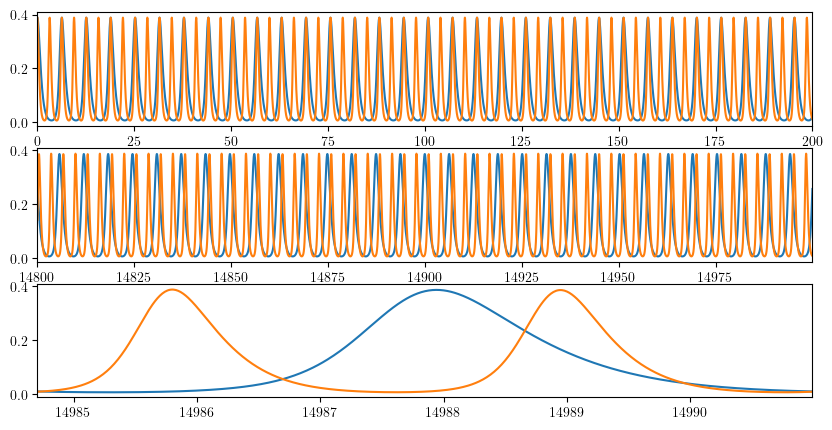

In [86]:
fig,axs = plt.subplots(3,1,figsize=(10,5))
axs[0].plot(solf12.t,solf12.y.T[:,0])
axs[0].plot(solf12.t,solf12.y.T[:,4])

axs[1].plot(solf12.t,solf12.y.T[:,0])
axs[1].plot(solf12.t,solf12.y.T[:,4])

axs[2].plot(solf12.t,solf12.y[0])
axs[2].plot(solf12.t,solf12.y[4])

axs[0].set_xlim(0,200)
axs[1].set_xlim(t12[-1]-200,t12[-1])
per = 2*np.pi
shift = 9
axs[2].set_xlim(t12[-1]-per-shift,t12[-1]-shift)

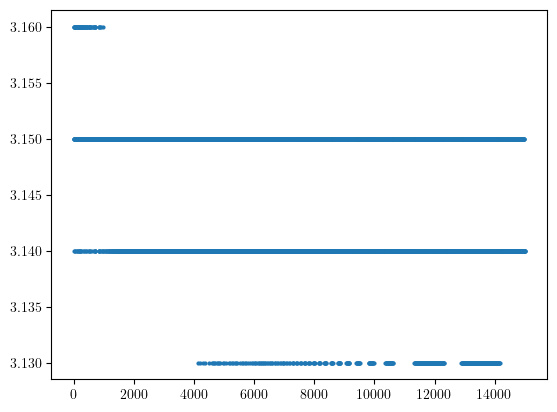

In [87]:
# plot frequency estimates
# check for steady-state.
peaks1 = sp.signal.find_peaks(solf12.y[0],prominence=.2)[0]
peaks2 = sp.signal.find_peaks(solf12.y[4],prominence=.2)[0]

fig,axs = plt.subplots()
#axs.scatter(solf12.t[peaks1],np.zeros(len(peaks1)),s=4)
#axs.scatter(solf12.t[peaks1],np.diff(solf12.t[peaks1],prepend=0),s=4)
axs.scatter(solf12.t[peaks2],np.diff(solf12.t[peaks2],prepend=0),s=4)

In [88]:
tp12a, phase12a = get_phase(t12,solf12.y.T[:,:4],skipn=50,system1=a12.system1)
tp12b, phase12b = get_phase(t12,solf12.y.T[:,4:],skipn=50,system1=a12.system2)

## Full vs phase Plot

(0.0, 6.283185307179586)

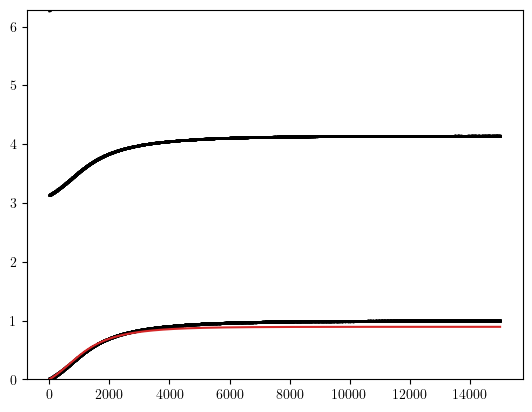

In [89]:
fig,axs = plt.subplots()
y = np.mod(phase12a - om*phase12b,2*np.pi)
axs.scatter(tp12a,y,s=1,alpha=.5,color='black')

axs.plot(t12,np.mod(solr12.y.T,2*np.pi),color='tab:red')
# axs.plot(t12,np.mod(solrs12.y[0]-a12.om*solrs12.y[1],2*np.pi),color='tab:orange')
#axs.scatter(sol_full.t[::skipn],np.mod(phase2,1),s=1)

axs.set_ylim(0,2*np.pi)

### Multiple Initial Conditions

In [25]:
init_phases12 = np.linspace(0,2*np.pi,5,endpoint=False)
dt = .01;T=40000
t12b = np.arange(0,T,dt)

y0b = a12.system2.lc['dat'][int((0/(2*np.pi))*a12.system2.TN),:]

full_1 = []
full_2 = []

args12b = {'args':(a12,eps12,del12),'t_eval':t12b,**kw_sim}

for i in range(len(init_phases12)):
    y0a = a12.system1.lc['dat'][int((init_phases12[i]/(2*np.pi))*a12.system1.TN),:]
    y0 = np.array([y0a,y0b]).flatten()

    solf12i = solve_ivp(_full,[0,t12b[-1]],y0,**args12b)
    tp12ai, phase12ai = get_phase(t12b,solf12i.y.T[:,:4],skipn=50,system1=a12.system1)
    tp12bi, phase12bi = get_phase(t12b,solf12i.y.T[:,4:],skipn=50,system1=a12.system2)

    full_1.append([tp12ai,phase12ai])
    full_2.append([tp12bi,phase12bi])

KeyboardInterrupt: 

In [ ]:
print(args12b,eps12)

In [ ]:
redu_1 = []
init_phases12b0 = np.linspace(0,2*np.pi,20,endpoint=False)
for i in range(len(init_phases12b0)):
    solr12i = solve_ivp(_redu,[0,t12b[-1]],[init_phases12b0[i]],**args12b)
    redu_1.append(solr12i)

In [ ]:
fig,axs = plt.subplots(2,1)
axs[0].plot(x_temp2,rhs)
axs[0].axhline(0,0,2*np.pi,ls='--',color='gray')

for i in range(len(init_phases12)):
    y = np.mod(full_1[i][1] - a12.om*full_2[i][1],2*np.pi)
    axs[1].scatter(y,full_1[i][0],s=1,alpha=.5,color='k')

for i in range(len(init_phases12b0)):
    axs[1].scatter(np.mod(redu_1[i].y[0],2*np.pi),redu_1[i].t,color='r',zorder=10,
               alpha=.5,s=1)


axs[0].set_xlim(0,2*np.pi)
axs[1].set_xlim(0,2*np.pi)

## Unaveraged

Compare simulations between full and reduced using non-averaged, original phase-isostable coordinates.

### Z,I functions lambdified

The psi/theta equations aren't implemented in the coupling case, so I'll do it here first.

I can't use `system1.K['sym']` or `system1.G['sym']` because they are both in terms of epsilon. I need to fall back to `system1.z['vec_psi']` and use `system1.z_og` to define a substitution rule. `a12.z_og` contains indexed variables used to define the $\psi$ expansion. 

`system1.z_og` is in the order: `zx0[0], zx0[1], zy0[0], zy0[1]`, i.e., variable 1, all orders, then next variable all orders, etc.

In [ ]:
print(a12.system1.z_og)

In [ ]:
print(a12.system1.i['vec_psi'])
print(a12.system1.z['vec_psi'])

In [ ]:
rule_var2imp = {}

# system 1
count = 0
for vname in a12.system1.var_names:
    for k in range(a12.system1.miter):
        rule_var2imp[a12.system1.z_og[count]] = a12.system1.z['imp_'+vname][k](a12.ths[0])
        rule_var2imp[a12.system1.i_og[count]] = a12.system1.i['imp_'+vname][k](a12.ths[0])
        rule_var2imp[a12.system1.g_og[count]] = a12.system1.g['imp_'+vname][k](a12.ths[0])
        count += 1
        
    #rule_var2imp[a12.system1.lc_og] = a12.system1.lc['imp_'+vname](a12.ths[0])

# system 2
count = 0
for vname in a12.system2.var_names:
    for k in range(a12.system2.miter):
        rule_var2imp[a12.system2.z_og[count]] = a12.system2.z['imp_'+vname][k](a12.ths[1])
        rule_var2imp[a12.system2.i_og[count]] = a12.system2.i['imp_'+vname][k](a12.ths[1])
        rule_var2imp[a12.system2.g_og[count]] = a12.system2.g['imp_'+vname][k](a12.ths[1])
        count += 1
        
    #rule_var2imp[a12.system2.lc_og] = a12.system2.lc['imp_'+vname](a12.ths[1])


print(rule_var2imp)

Now that I have the implemented functions, it's time to substitute out the symbols like `zx[0]` with the corresponding implemented function, then lambdify.

In [ ]:
print(a12.system1.i['vec_psi'].subs(rule_var2imp))
print(a12.system2.z['vec_psi'].subs(rule_var2imp))

In [ ]:
i_lam0 = sym.lambdify([a12.ths[0],a12.system1.psi],a12.system1.i['vec_psi'].subs(rule_var2imp).T)
z_lam0 = sym.lambdify([a12.ths[0],a12.system1.psi],a12.system1.z['vec_psi'].subs(rule_var2imp).T)

i_lam1 = sym.lambdify([a12.ths[1],a12.system2.psi],a12.system2.i['vec_psi'].subs(rule_var2imp).T)
z_lam1 = sym.lambdify([a12.ths[1],a12.system2.psi],a12.system2.z['vec_psi'].subs(rule_var2imp).T)

Define lambidfied functions for use in unaveraged rhs

In [ ]:
psi_sym = a12.system1.psi
# imp = a12.system1.lc['imp_x0'](a12.ths[0])+psi_sym*a12.system1.g['imp_x0'][1](a12.ths[0])+psi_sym**2*a12.system1.g['imp_x0'][2](a12.ths[0])
# x0_lam = sym.lambdify([a12.ths[0],psi_sym],imp)

# imp = a12.system1.lc['imp_y0'](a12.ths[0])+psi_sym*a12.system1.g['imp_y0'][1](a12.ths[0])+psi_sym**2*a12.system1.g['imp_y0'][2](a12.ths[0])
# y0_lam = sym.lambdify([a12.ths[0],psi_sym],imp)

# imp = a12.system1.lc['imp_z0'](a12.ths[0])+psi_sym*a12.system1.g['imp_z0'][1](a12.ths[0])+psi_sym**2*a12.system1.g['imp_z0'][2](a12.ths[0])
# z0_lam = sym.lambdify([a12.ths[0],psi_sym],imp)

imp = a12.system1.lc['imp_v0'](a12.ths[0])+psi_sym*a12.system1.g['imp_v0'][1](a12.ths[0])+psi_sym**2*a12.system1.g['imp_v0'][2](a12.ths[0])
v0_lam = sym.lambdify([a12.ths[0],psi_sym],imp)

In [ ]:
pd1 = a12.system1.pardict;pd2 = a12.system2.pardict

### rhs

In [93]:
def _redu_c(t,y,eps=0,del1=0):
    """full reduced model"""
    th0,ps0,th1,ps1 = y

    eps /= 2
    
    v0 = v0_lam(th0,ps0);v1 = v0_lam(th1,ps1)
    F = (v0+v1)/2;Ga = K*F/(kc+K*F)*pd1['om_fix0']

    dth0 = 1 + eps*z_lam0(th0,ps0)[0,0]*Ga + eps*del1*z_lam0(th0,ps0)[0,0]#*a12.system1.pardict['om_fix0']
    dps0 = a12.system1.kappa_val*ps0 + eps*i_lam0(th0,ps0)[0,0]*Ga
    
    dth1 = 1 + eps*z_lam1(th1,ps1)[0,0]*Ga
    dps1 = a12.system2.kappa_val*ps1 + eps*i_lam1(th1,ps1)[0,0]*Ga

    return np.array([dth0,dps0,dth1*m,dps1*m])

### Integrate

In [ ]:
tr = np.arange(0,40000,.02)
init = [th_init12,.0,0,.0]
out12_ua = solve_ivp(_redu_c,[tr[0],tr[-1]],init,args=(eps12,del12),t_eval=tr,**kw_sim)

In [ ]:
fig,axs = plt.subplots()
axs.plot(tr,out12_ua.y[0]-a12.om*out12_ua.y[2],alpha=.75)
y = np.mod(phase12a - a12.om*phase12b,2*np.pi)
axs.scatter(tp12a,y,s=1,alpha=.5,color='k')
axs.plot(t12,np.mod(solr12.y.T,2*np.pi),color='tab:red')
axs.set_ylim(-.1,2*np.pi+.1)

### Multiple Initial Conditions

In [ ]:
init_phases12b = np.linspace(0,2*np.pi,5,endpoint=False)

In [ ]:
phase_iso = []
t12c = np.arange(0,40000,.01)
for i in range(len(init_phases12b)):
    init = [init_phases12b[i],.0,0,.0]
    solr12b = solve_ivp(_redu_c,[0,t12c[-1]],init,args=(eps12,del12),t_eval=t12c,**kw_sim)
    phase_iso.append(solr12b)

In [ ]:
fig,axs = plt.subplots(2,1)
axs[0].plot(x_temp2,rhs)
axs[0].axhline(0,0,2*np.pi,ls='--',color='gray')

skipn = 1
for i in range(len(init_phases12)):
    y = np.mod(full_1[i][1] - a12.om*full_2[i][1],2*np.pi)
    axs[1].scatter(y[::skipn],full_1[i][0][::skipn],s=1,alpha=.5,color='k')
    axs[1].scatter(np.mod(redu_1[i].y[0],2*np.pi),redu_1[i].t,color='r',s=1,zorder=10)

skipn = 100
for i in range(len(init_phases12b)):
    y2 = np.mod(phase_iso[i].y[0] - a12.om*phase_iso[i].y[2],2*np.pi)
    axs[1].scatter(y2[::skipn],phase_iso[i].t[::skipn],color='b',s=1,zorder=20,alpha=.5)
    
#axs[0].set_xlim(0,2*np.pi)
#axs[1].set_xlim(0,2*np.pi)
plt.savefig('unave_blue_vs_full_black_vs_1d_red.png')

### Compare p_i functions between unaveraged and averaged

Need to use the same $\theta_i$ solution values when plugging into the $p_i$ functions to compare to $psi_i$.

In [ ]:
tha_0 = out12_ua.y[0]; thb_0 = out12_ua.y[2]
eps_0 = eps21
psi_approx_a = eps_0*a12.system1.p['lam'][1](tha_0,thb_0) + eps_0**2*a12.system1.p['lam'][2](tha_0,thb_0) + eps_0**3*a12.system1.p['lam'][3](tha_0,thb_0)
psi_approx_b = eps_0*a12.system2.p['lam'][1](tha_0,thb_0) + eps_0**2*a12.system2.p['lam'][2](tha_0,thb_0) + eps_0**3*a12.system1.p['lam'][3](tha_0,thb_0)

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(10,3))
axs[0].plot(out12_ua.t,psi_approx_a,alpha=.7)
axs[0].plot(out12_ua.t,out12_ua.y[1],alpha=.7)

axs[1].plot(out12_ua.t,psi_approx_b,alpha=.7)
axs[1].plot(out12_ua.t,out12_ua.y[3],alpha=.7)

I mean... the fact that these solutions agree and that the directly integrated $p_i$ functions agree with the precomputed $p_i$ functions means that the issue lies with $\mathcal{H}$ calculations and not before.

## Unaveraged, subtracted moving

### rhs

In [62]:
def _redu_nm(t,y,eps=0,del1=0):
    """full reduced model"""
    th0,ps0,th1,ps1 = y
    
    v0 = v0_lam(th0+om*t,ps0)
    v1 = v0_lam(th1+t,ps1)
    F = (v0+v1)/2;Ga = K*F/(kc+K*F)*pd1['om_fix0']

    dth0 = eps*z_lam0(th0+om*t,ps0)[0,0]*Ga + eps*del1
    dps0 = a12.system1.kappa_val*ps0 + eps*i_lam0(th0+om*t,ps0)[0,0]*Ga
    
    dth1 = eps*z_lam1(th1+t,ps1)[0,0]*Ga
    dps1 = a12.system2.kappa_val*ps1 + eps*i_lam1(th1+t,ps1)[0,0]*Ga

    return np.array([dth0/m,dps0/m,dth1,dps1])

### Integrate

In [63]:
tn = np.arange(0,5000,.01)
init = [th_init12,.0,0,.0]
out12_nm = solve_ivp(_redu_nm,[tn[0],tn[-1]],init,args=(eps12,del12),t_eval=tn,**kw_sim)

(-0.1, 6.383185307179586)

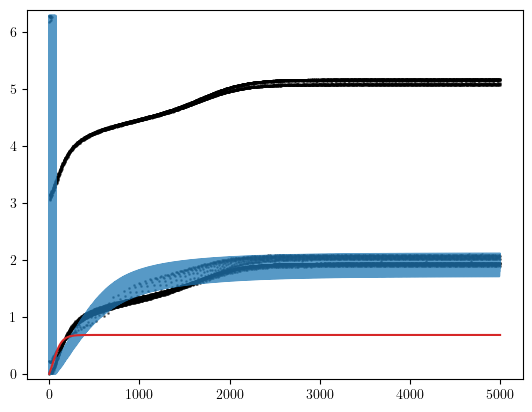

In [64]:
fig,axs = plt.subplots()
axs.plot(tn,np.mod(out12_nm.y[0]-a12.om*out12_nm.y[2],2*np.pi),alpha=.75)
y = np.mod(phase12a - a12.om*phase12b,2*np.pi)
axs.scatter(tp12a,y,s=1,alpha=.5,color='k')
axs.plot(t12,np.mod(solr12.y.T,2*np.pi),color='tab:red')
axs.set_ylim(-.1,2*np.pi+.1)

## Averaged brute

In [ ]:
# def _redu_nm(t,y,eps=0,del1=0):
#     """full reduced model"""
#     th0,ps0,th1,ps1 = y
    
#     v0 = v0_lam(th0+om*t,ps0)
#     v1 = v0_lam(th1+t,ps1)
#     F = (v0+v1)/2;Ga = K*F/(kc+K*F)*pd1['om_fix0']

#     dth0 = eps*z_lam0(th0+om*t,ps0)[0,0]*Ga + eps*del1
#     dps0 = a12.system1.kappa_val*ps0 + eps*i_lam0(th0+om*t,ps0)[0,0]*Ga
    
#     dth1 = eps*z_lam1(th1+t,ps1)[0,0]*Ga
#     dps1 = a12.system2.kappa_val*ps1 + eps*i_lam1(th1+t,ps1)[0,0]*Ga

#     return np.array([dth0/m,dps0/m,dth1,dps1])

### rhs

In [ ]:
# finer mesh doesn't seem to make a difference.
s2,ds2 = np.linspace(0,2*np.pi*m,int(2*np.pi*m/.01),retstep=True,endpoint=True)

In [ ]:
def _redu_b(t,y,eps=0,del1=0):
    """full reduced model note that this works even with the $p_i$ functions in place of psi"""
    th0,ps0,th1,ps1 = y
    
    v0 = v0_lam(th0+om*s2,ps0)
    v1 = v0_lam(th1+s2,ps1)
    F = (v0+v1)/2;Ga = K*F/(kc+K*F)*pd1['om_fix0']
    
    dth0 = eps*np.sum(z_lam0(th0+om*s2,ps0)[0,0]*Ga)*ds2/(2*np.pi*m) + eps*del1*a12.system1.pardict['om_fix0']
    dps0 = a12.system1.kappa_val*ps0 + eps*np.sum(i_lam0(th0+om*s2,ps0)[0,0]*Ga)*ds2/(2*np.pi*m)

    dth1 = eps*np.sum(z_lam1(th1+s2,ps1)[0,0]*Ga)*ds2/(2*np.pi*m)
    dps1 = a12.system2.kappa_val*ps1 + eps*np.sum(i_lam1(th1+s2,ps1)[0,0]*Ga)*ds2/(2*np.pi*m)

    return np.array([dth0/m,dps0/m,dth1,dps1])

In [ ]:
# def _redu_b(t,y,eps=0,del1=0):
#     """full reduced model note that this works even with the $p_i$ functions in place of psi."""
#     th0,ps0,th1,ps1 = y
#     phi = th0 - a12.om*th1;phi2 = (phi + a12.om*s)
#     v0 = v0_lam(phi2,ps0); v1 = v0_lam(s,ps1)
#     F = (v0+v1)/2;Ga = K*F/(kc+K*F)*pd1['om_fix0']
    
#     dth0 = eps*np.sum(z_lam0(phi2,ps0)[0,0]*Ga)*ds/(2*np.pi*m) + eps*del1
#     dps0 = a12.system1.kappa_val*ps0 + eps*np.sum(i_lam0(phi2,ps0)[0,0]*Ga)*ds/(2*np.pi*m)

#     dth1 = eps*np.sum(z_lam1(s,ps1)[0,0]*Ga)*ds/(2*np.pi*m)
#     dps1 = a12.system2.kappa_val*ps1 + eps*np.sum(i_lam1(s,ps1)[0,0]*Ga)*ds/(2*np.pi*m)

#     return np.array([dth0/m,dps0/m,dth1,dps1])

### Integrate

In [ ]:
tq = np.arange(0,40000,.01)
init = [th_init12,.0,0,.0]
# init = [1.75,.0,0,.0]
out12_ub = solve_ivp(_redu_b,[tq[0],tq[-1]],init,args=(eps12,del12),t_eval=tq,**kw_sim)

In [ ]:
fig,axs = plt.subplots()
axs.plot(tq,np.mod(out12_ub.y[0]-a12.om*out12_ub.y[2],2*np.pi),label='avg1')
y = np.mod(phase12a - a12.om*phase12b,2*np.pi)
axs.scatter(tp12a,y,s=1,alpha=.5,color='k')
# axs.plot(tn,np.mod(out12_nm.y[0]-a12.om*out12_nm.y[2],2*np.pi),alpha=.75,label='move')
# axs.plot(t12,np.mod(solr12.y.T,2*np.pi),color='tab:red')
axs.set_ylim(-.1,2*np.pi+.1);axs.legend()

### Multiple Initial Conditions

In [ ]:
phase_iso_avg = []
init_phases12bb = np.linspace(0,2*np.pi,10,endpoint=False)
t = np.arange(0,40000,.01)
for i in range(len(init_phases12bb)):
    init = [init_phases12bb[i],.0,0,.0]
    solr12c = solve_ivp(_redu_b,[0,t[-1]],init,args=(eps12,del12),t_eval=t,**kw_sim)
    phase_iso_avg.append(solr12c)

In [ ]:
fig,axs = plt.subplots(2,1)
axs[0].plot(x_temp2,rhs)
axs[0].axhline(0,0,2*np.pi,ls='--',color='gray')

skipn = 1
# for i in range(len(init_phases12)):
    # y = np.mod(full_1[i][1] - a12.om*full_2[i][1],2*np.pi)
    # axs[1].scatter(y[::skipn],full_1[i][0][::skipn],s=1,alpha=.5,color='k')

for i in range(len(init_phases12b0)):
    axs[1].scatter(np.mod(redu_1[i].y[0],2*np.pi),redu_1[i].t,color='r',s=1,zorder=10)

skipn = 100
for i in range(len(init_phases12b)):
    y2 = np.mod(phase_iso[i].y[0] - a12.om*phase_iso[i].y[2],2*np.pi)
    axs[1].scatter(y2[::skipn],phase_iso[i].t[::skipn],color='b',s=1,zorder=20,alpha=.5)

skipn=50
for i in range(len(init_phases12bb)):
    y2 = np.mod((phase_iso_avg[i].y[0] - a12.om*phase_iso_avg[i].y[2]),2*np.pi)
    axs[1].scatter(y2[::skipn],phase_iso_avg[i].t[::skipn],color='g',s=1,zorder=20,alpha=.5)


#axs[0].set_xlim(0,2*np.pi)
#axs[1].set_xlim(0,2*np.pi)
# plt.savefig('ave_blue_vs_full_black_vs_1d_red.png')

## Check phase indexing

In [ ]:
# check indexing for phase
sol_arr = solf12.y.T[:2000,:4]

fig,axs = plt.subplots()
axs.plot(sol_arr[:,0])

phase_value = []


for i in range(len(sol_arr)):
    d1 = np.linalg.norm(sol_arr[i,:]-a12.system1.lc['dat'],axis=1)
    phase_value.append(np.argmin(d1)/len(system1.lc['dat']))

axs.plot(phase_value)

# 2:1

In [28]:
a21 = nm.nmCoupling(system1,system2,
                    #recompute_list=['p_data_gw0','p_data_gw1','h_data_gw0','h_data_gw1'],
                    #recompute_list=recompute_list,
                    _n=('om0',2),_m=('om1',1),
                    NP=700,
                    NH=700,
                    save_fig=False)

* Loading p symbolic...
* Loading p symbolic...
* Loading H symbolic...
* Loading H symbolic...
* Loading H gw0, order=0...
* Loading H gw1, order=0...
* Loading H gw0, order=1...
* Loading H gw1, order=1...
* Loading H gw0, order=2...
* Loading H gw1, order=2...


In [94]:
eps21 = .005
del21 = 0.0
th_init21 = 0

First order starts losing accuracy around eps = 0.025 as eps increases (the reduced model reaches the same fixed point as the full model). Even at eps=0.02, the reduced and full models don't coincide in transients despite the long-term convergence.

Using order eps^2 at eps = 0.025 results in WORSE performance... So clearly if not p then there is something wrong with calculating h functions...

## Phase plane

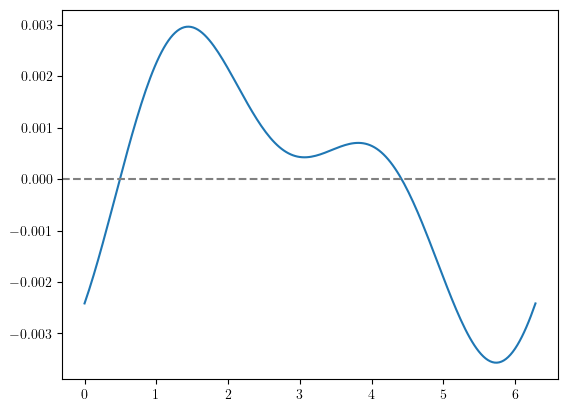

In [95]:
x_temp2 = np.linspace(0,2*np.pi,200)

rhs = _redu(0,x_temp2,a21,eps21,del21)

fig,axs = plt.subplots()
axs.plot(x_temp2,rhs)
axs.axhline(0,0,2*np.pi,ls='--',color='gray')

## Integrate

In [102]:
dt = .05;T=20000
t21 = np.arange(0,T,dt)
args21 = {'args':(a21,eps21,del21),'t_eval':t21,**kw_sim}

In [103]:
y0a = a21.system1.lc['dat'][int((th_init21/(2*np.pi))*a21.system1.TN),:]
y0b = a21.system2.lc['dat'][int((0/(2*np.pi))*a21.system2.TN),:]

y0 = np.array([y0a,y0b]).flatten()

solf21 = solve_ivp(_full,[0,t21[-1]],y0,**args21)

In [109]:
solr21 = solve_ivp(_redu,[0,t21[-1]],[th_init21],**args21)

(19799.95, 19999.95)

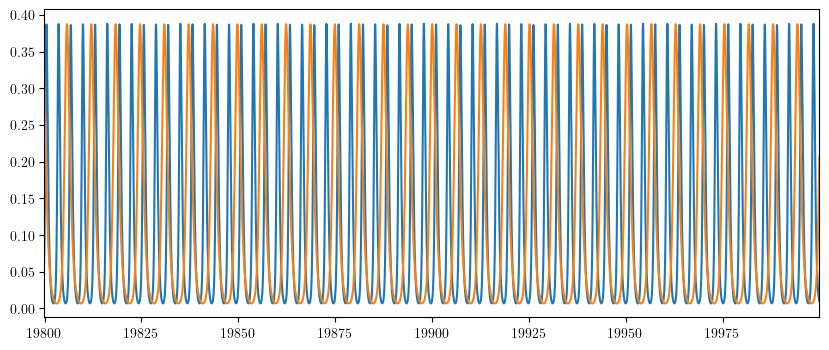

In [105]:
fig,axs = plt.subplots(figsize=(10,4))
axs.plot(solf21.t,solf21.y.T[:,0])
axs.plot(solf21.t,solf21.y.T[:,4])
#axs.set_xlim(sol_full.t[-1]-200,sol_full.t[-1])
axs.set_xlim(t21[-1]-200,t21[-1])

In [106]:
tp21a, phase21a = get_phase(t21,solf21.y.T[:,:4],skipn=50,system1=a21.system1)
tp21b, phase21b = get_phase(t21,solf21.y.T[:,4:],skipn=50,system1=a21.system2)

## Full vs phase

(0.0, 6.283185307179586)

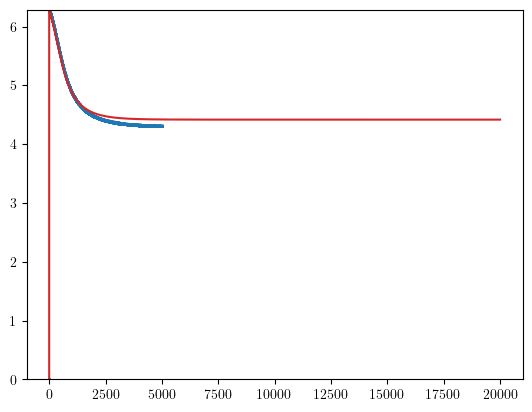

In [112]:
fig,axs = plt.subplots()
y = np.mod(phase21a - a21.om*phase21b,2*np.pi)
axs.scatter(tp21a/4,y,s=1,alpha=.5)
axs.plot(t21,np.mod(solr21.y.T,2*np.pi),color='tab:red')
#axs.scatter(sol_full.t[::skipn],np.mod(phase2,1),s=1)
axs.set_ylim(0,2*np.pi)

## Bifurcations

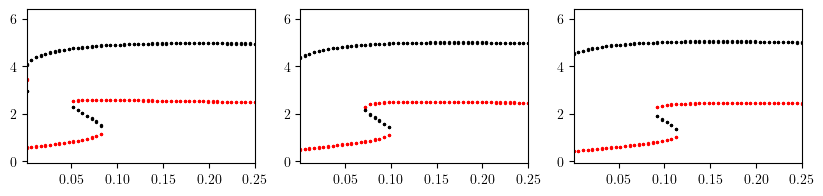

In [37]:
fig,axs=plt.subplots(1,3,figsize=(10,2))

del_list21 = np.linspace(-.002,.002,3)
eps_list21 = np.linspace(0.001,.25,50)

for k in range(len(del_list21)):
    add_diagram(axs[k],a21,del_list21[k],eps_list21)